In [1]:
%load_ext autoreload
%autoreload 2
from dds.configs.config import set_task, get_config
from dds.train_dds import train_dds
import numpy as onp
import jax
from turtle import forward

import distrax
import jax.numpy as jnp
import haiku as hk
from jaxline import utils

import functools
import timeit
from typing import Any, List, Tuple, Optional
from absl import app, flags

from absl import logging
import haiku as hk
import distrax
import jax
import jax.numpy as jnp

from ml_collections import config_dict as configdict
from ml_collections import config_flags

import numpy as onp
import optax

from jaxline import utils

from dds.configs.config import set_task
from dds.data_paths import results_path
from dds.utils import flatten_nested_dict
import wandb
print(jax.devices())

2023-08-21 13:12:21.266757: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-21 13:12:21.830814: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-21 13:12:21.830887: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-21 13:12:21.830894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [24]:
from dds.objectives import controlled_ais_relative_kl_objective
from dds.objectives import controlled_ais_importance_weighted_partition_estimate_dds
import matplotlib.pyplot as plt


config = get_config()

# Time and step settings (Need to be done before calling set_task)
config.model.tfinal = 6.4
# config.model.tfinal = 10
config.model.dt = 0.05

config.model.reference_process_key = "cais"
# config.model.reference_process_key = "ula"

config.trainer.objective = controlled_ais_relative_kl_objective
config.trainer.lnz_is_estimator = controlled_ais_importance_weighted_partition_estimate_dds

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"

config = set_task(config, "ion")

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"
    
    # Opt setting for funnel
    config.model.sigma = 1.
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False

if config.model.reference_process_key == "cais"  or config.model.reference_process_key == "ula":
    config.model.step_scheme_key = "uniform"
    
    # Opt setting for funnel
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False
    config.trainer.lr_sch_base_dec = 0.97
    config.trainer.learning_rate = 1 * 10**(-5)
    
    if config.task == "funnel": # lnZ: 0.4, ELBO: 1.6
        config.model.sigma = 1.25
        config.model.sigma_base = 1.75
        config.trainer.learning_rate = 1 * 10**(-5)
        config.trainer.lr_sch_base_dec = 0.95 # For funnel
        
    if config.task == "lr_sonar": # lnZ: -109.1, ELBO: -114.76
        config.model.sigma = 0.5
        config.model.sigma_base = 0.6
    
    if config.task == "ion":     # lnZ: -112.275, ELBO: -117.619
        config.model.sigma = 0.5
        config.model.sigma_base = 0.7
    
    if config.task == "lgcp":  # lnZ: 473, ELBO: 413
        config.model.sigma = 4.6
        config.model.sigma_base = 2.3
    


config.model.stl = False
config.model.detach_stl_drift = False

config.trainer.notebook = True
config.trainer.epochs = 200  #  11000
# Opt settings we use
# funnel_config.trainer.learning_rate = 0.0001
config.trainer.learning_rate = 1 * 10**(-3)

# config.trainer.learning_rate = 1e-2


# config.model.reference_process_key = "cais"
# config.trainer.learning_rate = 0
config.trainer.epochs = 2000
# config.trainer.epochs = 1
config.model.sigma, config.model.sigma_base

(0.5, 0.7)

0 254.42755126953125
1 219.8680419921875
2 198.0738525390625
3 180.60394287109375
4 168.74940490722656
5 162.04327392578125
6 155.855224609375
7 149.43844604492188
8 144.0780792236328
9 140.1310577392578
10 137.36965942382812
11 135.57427978515625
12 134.23944091796875
13 133.12423706054688
14 131.97232055664062
15 130.74166870117188
16 129.57470703125
17 128.49940490722656
18 127.54904174804688
19 126.9100570678711
20 126.42581939697266
21 125.9598159790039
22 125.50957489013672
23 125.05403137207031
24 124.66556549072266
25 124.3821029663086
26 124.24720764160156
27 124.15118408203125
28 124.11151885986328
29 124.10140228271484
30 124.11688232421875
31 124.11454010009766
32 124.09817504882812
33 124.03870391845703
34 123.97474670410156
35 123.89302062988281
36 123.83885192871094
37 123.83392333984375
38 123.83678436279297
39 123.78640747070312
40 123.7200927734375
41 123.66201782226562
42 123.6380386352539
43 123.61821746826172
44 123.59048461914062
45 123.56842041015625
46 123.55482

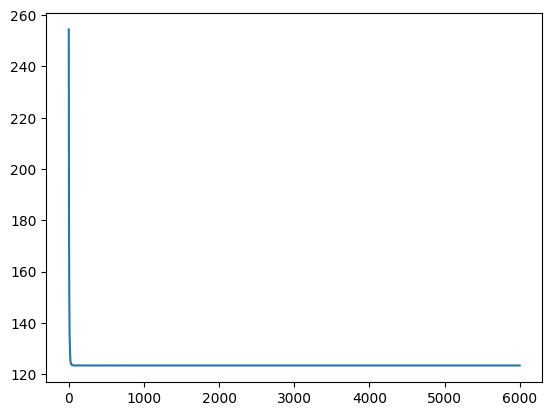

In [25]:
def mfvi_init(
    config=config,
    sigma_init=config.model.sigma_base,
    dim=config.model.input_dim,
    target=config.model.target
):
    device_no = jax.device_count()
    batch_size_ = config.model.batch_size / device_no
    start = 0
    seed = config.trainer.random_seed  if "random_seed" in config.trainer else 42
    lnpi = config.trainer.lnpi
    
    seq = hk.PRNGSequence(seed)
    rng_key = next(seq)
    subkeys = utils.bcast_local_devices(rng_key)

    def _forward_fn_mfvi(batch_size: int) -> jnp.ndarray:

        mus = hk.get_parameter(
          name="mus",
          shape=(dim,),
          init=hk.initializers.Constant(0.)
        )

        sigmas = hk.get_parameter(
          name="sigmas",
          shape=(dim,),
          init=hk.initializers.Constant(0.)
        )

        init_dist = distrax.MultivariateNormalDiag(
            mus ,
            sigmas
        )
        return init_dist.sample(
            seed=rng_key, sample_shape=batch_size), init_dist.entropy()

    forward_fn_mfvi = hk.transform_with_state(_forward_fn_mfvi) 
    
    p_init_fn_mfvi = jax.pmap(
        functools.partial(forward_fn_mfvi.init, batch_size=batch_size_,),
        axis_name="num_devices")

    params, model_state = p_init_fn_mfvi(subkeys)


    clipper = optax.clip(1.0)
    base_dec = config.trainer.lr_sch_base_dec
    scale_by_adam = optax.scale_by_adam()

    transition_steps = 50
    exp_lr = optax.exponential_decay(100 * config.trainer.learning_rate,
                                    transition_steps, base_dec)
    scale_lr = optax.scale_by_schedule(exp_lr)
    opt = optax.chain(clipper, scale_by_adam, scale_lr, optax.scale(-1))

    opt_state = jax.pmap(opt.init)(params)
    
    
    def full_objective_mfvi(
        params,
        model_state: hk.State,
        rng_key: jnp.ndarray,
        batch_size: int
    ):
        
        (X, entropy), model_state = forward_fn_mfvi.apply(
          params, model_state, rng_key, batch_size
        )
        
        cross_ent = -lnpi(X).mean()

        loss = cross_ent - entropy
        return loss, model_state
    
    @functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(4,))
    def update_mfvi(
        params,
        model_state: hk.State,
        opt_state: Any,
        rng_key: jnp.ndarray,
        batch_size: jnp.ndarray):

      grads, new_model_state = jax.grad(
          full_objective_mfvi, has_aux=True)(
              params,
              model_state,
              rng_key,
              batch_size)
      grads = jax.lax.pmean(grads, axis_name="num_devices")

      updates, opt_state = opt.update(grads, opt_state)
      new_params = optax.apply_updates(params, updates)
      return new_params, opt_state, new_model_state

    @functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(3,))
    def jited_val_loss_mfvi(
        params,
        model_state: hk.State,
        rng_key: jnp.ndarray,
        batch_size: jnp.ndarray):

      loss, new_model_state = full_objective_mfvi(params,
                                             model_state,
                                             rng_key,
                                             batch_size_)

      loss = jax.lax.pmean(loss, axis_name="num_devices")
      return loss, new_model_state
    
    losses = []

    for epoch in range(start, 3 * config.trainer.epochs):
    # for epoch in range(start, start+1):

        rng_key = next(seq)
        subkeys = jax.random.split(rng_key, device_no)

        params, opt_state, model_state = update_mfvi(params,
                                                     model_state, opt_state,
                                                     subkeys, batch_size_)
        loss, _ = jited_val_loss_mfvi(params,
                                     model_state,
                                    subkeys, batch_size_)
        print(epoch, loss.item())
        losses.append(loss.item())
    
    init_dist = distrax.MultivariateNormalDiag(
            jnp.squeeze(params["~"]["mus"]),
            jnp.squeeze(params["~"]["sigmas"])
    )
    return init_dist, losses, jnp.squeeze(params["~"]["mus"]), jnp.squeeze(params["~"]["sigmas"])

init_dist, losses, init_mu, init_sigma = mfvi_init()

plt.plot(losses)

In [26]:
def update_detached_params(trainable_params, non_trainable_params,
                           attached_network_name="simple_drift_net",
                           detached_network_name="stl_detach"):
  """Auxiliary function updating detached params for STL.

  Args:
      trainable_params:
      non_trainable_params:
      attached_network_name:
      detached_network_name:
  Returns:
    Returns non trainable params
  """

  if len(trainable_params) != len(non_trainable_params):
    return non_trainable_params

  for key in trainable_params.keys():
    if attached_network_name in key:
      key_det = key.replace(attached_network_name, detached_network_name)
    else:
      key_det = key.replace("diffusion_network",
                            detached_network_name + "_diff")
    non_trainable_params[key_det] = trainable_params[key]  # pytype: disable=unsupported-operands

  return non_trainable_params

data_dim = config.model.input_dim
device_no = jax.device_count()

results_path = '~/denoising_diffusion_samplers/results'
alpha = config.model.alpha
sigma = config.model.sigma
m = config.model.m

if config.model.reference_process_key == "oudstl":
    config.model.sigma_base = config.model.sigma

# post setup model vars
# config.model.source_obj = init_dist
# # config.model.source_obj = distrax.MultivariateNormalDiag(
# #     jnp.zeros(config.model.input_dim),
# #     config.model.sigma_base * jnp.ones(config.model.input_dim))
# config.model.source = config.model.source_obj.log_prob

batch_size_ = int(config.model.batch_size / device_no)
batch_size_elbo = int(config.model.elbo_batch_size / device_no)

step_scheme = config.model.step_scheme_dict[config.model.step_scheme_key]

dt = config.model.dt

if config.model.reference_process_key == "oududp":
    key_conversion = {
        "pis": "pisudp",
        "vanilla": "vanilla_udp",
        "tmpis": "tmpis_udp"
    }
    # "pisudp"
    config.model.network_key = key_conversion[config.model.network_key]

net_key = config.model.network_key
network = config.model.network_dict[net_key]

tpu = config.model.tpu

detach_dif_path, detach_dritf_path = (
    config.model.detach_path, config.model.detach_path)

target = config.model.target

tfinal = config.model.tfinal
lnpi = config.trainer.lnpi

ref_proc_key = config.model.reference_process_key
ref_proc = config.model.reference_process_dict[ref_proc_key]

trim = (2 if "stl" in str(ref_proc).lower() or "udp" in str(ref_proc).lower()
        else 1)

stl = config.model.stl

brown = "brown" in str(ref_proc).lower()

seed = config.trainer.random_seed  if "random_seed" in config.trainer else 42

# task directory (currently not in use)
task = config.task
method = config.model.reference_process_key
task_path = results_path + f"/{task}" + f"/{ref_proc_key}" + f"/{net_key}"
task_path += f"/{method}"


# checkpoiting variables for wandb
nsteps = config.model.ts.shape[0]
keep_every_nth = int(config.trainer.epochs / 125)
file_name = (f"/alpha_{alpha}_sigma_{sigma}_epochs_{config.trainer.epochs}" +
            f"_task_{task}_seed_{seed}_steps_{nsteps}_stl_{stl}_{method}" +
            f"_scheme_{config.model.step_scheme_key}_ddpm_test11_chk")
_ = task_path + file_name

detach_stl_drift = (
    config.model.detach_stl_drift if
    "detach_stl_drift" in config.model else False
)

drift_network = lambda: network(config.model, data_dim, "simple_drift_net")

############## wandb logging  place holder ################
data_id = "denoising_diffusion_samplers"  # Project name

In [27]:
from turtle import forward


def _forward_fn(batch_size: int,
                training: bool = True,
                ode=False, exact=False, dt_=dt) -> jnp.ndarray:
    mus = hk.get_parameter(
          name="mus",
          shape=(config.model.input_dim,),
          init=lambda x, y: init_mu,
        )

    sigmas = hk.get_parameter(
        name="sigmas",
        shape=(config.model.input_dim,),
        init=lambda x, y: init_sigma
    )

    source_dist = distrax.MultivariateNormalDiag(
            mus,
            sigmas
    )
    config.model.source_obj = source_dist
    config.model.source = config.model.source_obj.log_prob

    drift_network = lambda: network(config.model, config.model.input_dim, "simple_drift_net")
    # source_dist = distrax.MultivariateNormalDiag(
    #     mus,
    #     sigmas
    # )
    
    # # config.model.source_obj = distrax.MultivariateNormalDiag(
    # #     jnp.zeros(config.model.input_dim),
    # # config.model.sigma_base * jnp.ones(config.model.input_dim)
    
    model_def = ref_proc(
        sigma, 
        data_dim, 
        drift_network, 
        tfinal=tfinal, 
        dt=dt_,
        step_scheme=step_scheme, 
        alpha=alpha, 
        target=target, 
        tpu=tpu,
        detach_stl_drift=detach_stl_drift, 
        diff_net=None,
        detach_dritf_path=detach_dritf_path, 
        detach_dif_path=detach_dif_path,
        m=m, 
        log=config.model.log, 
        exp_bool=config.model.exp_dds, 
        exact=exact,
        init_dist=init_dist,
    )

    return model_def(batch_size, training, ode=ode)

forward_fn = hk.transform_with_state(_forward_fn)  

print(forward_fn)


TransformedWithState(init=<function transform_with_state.<locals>.init_fn at 0x7f8220199a20>, apply=<function transform_with_state.<locals>.apply_fn at 0x7f8220199870>)


In [28]:
# opt and loss setup
seq = hk.PRNGSequence(seed)
rng_key = next(seq)
# subkeys = jax.random.split(rng_key, device_no)
subkeys = utils.bcast_local_devices(rng_key)

p_init = jax.pmap(
    functools.partial(forward_fn.init, batch_size=batch_size_,
                        training=True), axis_name="num_devices")

params, model_state = p_init(subkeys)

trainable_params, non_trainable_params = hk.data_structures.partition(
    lambda module, name, value: "stl_detach" not in module, params)

clipper = optax.clip(1.0)
base_dec = config.trainer.lr_sch_base_dec
scale_by_adam = optax.scale_by_adam()
# if base_dec == 0:
#   scale_by_lr = optax.scale(-config.trainer.learning_rate)
#   opt = optax.chain(clipper, scale_by_adam, scale_by_lr)
# else:
transition_steps = 50
exp_lr = optax.exponential_decay(config.trainer.learning_rate,
                                transition_steps, base_dec)
scale_lr = optax.scale_by_schedule(exp_lr)
opt = optax.chain(clipper, scale_by_adam, scale_lr, optax.scale(-1))

# opt = optax.adam(learning_rate=config.trainer.learning_rate)
opt_state = jax.pmap(opt.init)(trainable_params)

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(3, 4, 5, 6))
def forward_fn_jit(
    params,
    model_state: hk.State,
    subkeys: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False,  dt_=dt):

    samps, _ = forward_fn.apply(
        params,
        model_state,
        subkeys,
        int(batch_size / device_no),
        False,
        ode=ode, exact=exact, dt_=dt_)
    samps = jax.device_get(samps)

    augmented_trajectory, ts = samps
    return (augmented_trajectory, ts), _

def forward_fn_wrap(
    params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False, dt_=dt):
    subkeys = jax.random.split(rng_key, device_no)
    (augmented_trajectory, ts), _ = forward_fn_jit(params, model_state,
                                                subkeys, batch_size, ode, exact,
                                                dt_)

    dv, ns, t, _ = augmented_trajectory.shape
    augmented_trajectory = augmented_trajectory.reshape(dv*ns, t, -1)
    return (augmented_trajectory, utils.get_first(ts)), _

In [29]:
def full_objective(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    is_training: bool = True,
    ode: bool = False,
    stl: bool = False,
    exact: bool = False,
  ):

  params = hk.data_structures.merge(trainable_params, non_trainable_params)
  (augmented_trajectory, _), model_state = forward_fn.apply(
      params, model_state, rng_key, batch_size, True, ode, exact
  )

  # import pdb; pdb.set_trace()
  gpartial = functools.partial(
      config.model.terminal_cost,
      lnpi=lnpi, sigma=sigma, tfinal=tfinal, brown=brown)
  
  if is_training:
    loss = config.trainer.objective(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, stl=stl, trim=trim, dim=data_dim)
  elif not ode:
    loss = config.trainer.lnz_is_estimator(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, dim=data_dim)
  else:
    loss = config.trainer.lnz_pf_estimator(
        augmented_trajectory, config.model.source, config.model.target)
  return loss, model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(5,))
def update(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    opt_state: Any,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray):
  grads, new_model_state = jax.grad(
      full_objective, has_aux=True)(
          trainable_params,
          non_trainable_params,
          model_state,
          rng_key,
          batch_size,
          is_training=True,
          stl=stl)
  grads = jax.lax.pmean(grads, axis_name="num_devices")

  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(trainable_params, updates)
  return new_params, opt_state, new_model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(4, 5, 6, 7))
def jited_val_loss(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray,
    is_training: bool = True,
    ode: bool = False,
    exact: bool = False,):

  loss, new_model_state = full_objective(
      trainable_params,
      non_trainable_params,
      model_state,
      rng_key,
      batch_size,
      is_training=is_training, ode=ode,
      stl=False, exact=exact,)

  loss = jax.lax.pmean(loss, axis_name="num_devices")
  return loss, new_model_state

def eval_report(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    epoch: int,
    loss_list: List[float],
    is_training: bool = True,
    print_flag: bool = False,
    ode: bool = False,
    exact: bool = False,
    wandb_run=None,
    wandb_key: Optional[str] = None,
) -> None:

  loss, model_state = jited_val_loss(
      trainable_params, non_trainable_params,
      model_state, rng_key, batch_size, is_training, ode, exact)
  loss = jax.device_get(loss)
  loss = onp.asarray(utils.get_first(loss).item()).item()

  log_string = "epoch: %s %s  loss: %s", epoch, "TRAIN", loss
  logging.info(log_string)
  if config.trainer.notebook and print_flag: print(log_string)

  loss_list.append(loss)
  if wandb_run:
    wandb_run.log({f"{wandb_key}/epoch": epoch, f"{wandb_key}/loss": loss})
  # writer.flush()

loss_list = []
loss_list_is = []
loss_list_pf = []

start = 0
times = []

run = None

for epoch in range(start, config.trainer.epochs):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  
  if epoch == 0:
      eval_report(trainable_params, non_trainable_params,
                    model_state, subkeys, batch_size_elbo, epoch - 1,
                    loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")
  if config.trainer.epochs == 1:
    break

  trainable_params, opt_state, model_state = update(trainable_params,
                                                    non_trainable_params,
                                                    model_state, opt_state,
                                                    subkeys, batch_size_)
  if config.trainer.timer:
    def func():
      return jax.block_until_ready(
          update(trainable_params, non_trainable_params, model_state,
                opt_state, subkeys, batch_size_))

    delta_time = timeit.timeit(func, number=1)
    times.append(delta_time)

  update_detached_params(trainable_params, non_trainable_params,
                        "simple_drift_net", "stl_detach")

  if epoch % config.trainer.log_every_n_epochs == 0:

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_is, is_training=False, wandb_run=run, wandb_key="is_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_pf, is_training=False, ode=True, wandb_run=run, wandb_key="pf_results")

    lr = onp.asarray(exp_lr(epoch).item()).item()
    if run:
        run.log({"lr/epoch": epoch, "lr/lr": lr})

print("TRAINING COMPLETED")
loss_list_is_eval, loss_list_eval, loss_list_pf_eval = [], [], []
for i in range(config.eval.seeds):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_eval,
      print_flag=True,
      wandb_run=run,
      wandb_key="elbo_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_is_eval,
      is_training=False,
      wandb_run=run,
      wandb_key="is_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_pf_eval,
      is_training=False, ode=True, exact=False,
      wandb_run=run,
      wandb_key="pf_results_eval",)

params = hk.data_structures.merge(trainable_params, non_trainable_params)
if config.trainer.timer:
  print(times[1:])

samps = 2500
if method == "lgcp" and tfinal >= 12:
  samps = 100

(augmented_trajectory, _), _ = forward_fn_wrap(params, model_state, rng_key,
                                              samps)

(augmented_trajectory_det, _), _ = forward_fn_wrap(params, model_state,
                                                  rng_key, samps, True, False)
  
(augmented_trajectory_det_ext, _), _ = forward_fn_wrap(params, model_state,
                                                      rng_key, samps, True, True)


results_dict = {
    "elbo": loss_list,
    "is": loss_list_is,
    "pf": loss_list_pf,
    "elbo_eval": loss_list_eval,
    "is_eval": loss_list_is_eval,
    "pf_eval": loss_list_pf_eval,
    "aug": augmented_trajectory,
    "aug_ode": augmented_trajectory_det,
    "aug_ode_ext": augmented_trajectory_det_ext
}

('epoch: %s %s  loss: %s', -1, 'TRAIN', 146.06655883789062)
('epoch: %s %s  loss: %s', 0, 'TRAIN', 140.68238830566406)
('epoch: %s %s  loss: %s', 1, 'TRAIN', 139.5387420654297)
('epoch: %s %s  loss: %s', 2, 'TRAIN', 134.50599670410156)
('epoch: %s %s  loss: %s', 3, 'TRAIN', 130.2172393798828)
('epoch: %s %s  loss: %s', 4, 'TRAIN', 129.99749755859375)
('epoch: %s %s  loss: %s', 5, 'TRAIN', 129.83348083496094)
('epoch: %s %s  loss: %s', 6, 'TRAIN', 129.47842407226562)
('epoch: %s %s  loss: %s', 7, 'TRAIN', 129.92453002929688)
('epoch: %s %s  loss: %s', 8, 'TRAIN', 129.06353759765625)
('epoch: %s %s  loss: %s', 9, 'TRAIN', 127.84807586669922)
('epoch: %s %s  loss: %s', 10, 'TRAIN', 126.23859405517578)
('epoch: %s %s  loss: %s', 11, 'TRAIN', 126.05599212646484)
('epoch: %s %s  loss: %s', 12, 'TRAIN', 124.92877960205078)
('epoch: %s %s  loss: %s', 13, 'TRAIN', 125.37586212158203)
('epoch: %s %s  loss: %s', 14, 'TRAIN', 124.85920715332031)
('epoch: %s %s  loss: %s', 15, 'TRAIN', 123.67817687

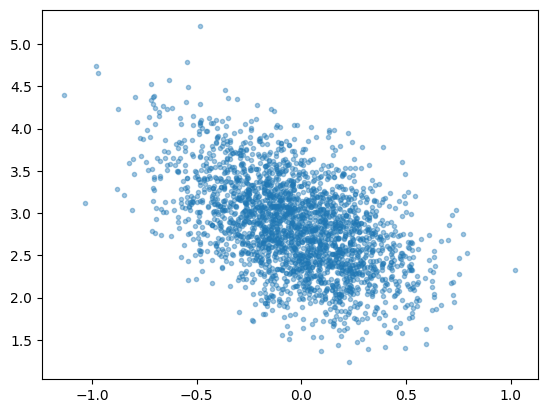

In [33]:
import matplotlib.pyplot as plt

# ode_targ = results_dict["aug_ode"][:, -1,:2]
sde_targ = results_dict["aug"][:, -1,:2]


# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ[:, 0], sde_targ[:, 1], ".", alpha=0.4)


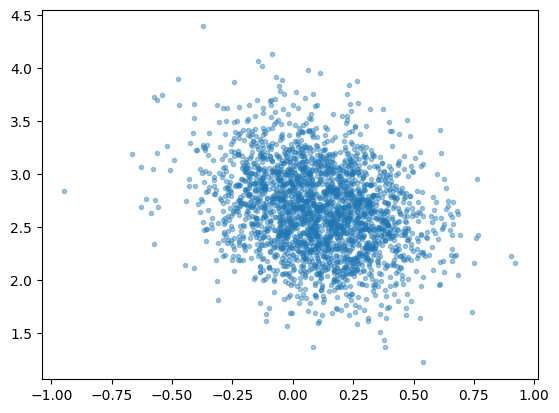

In [34]:
timestep = 90

sde_targ2 = results_dict["aug"][:, timestep,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ2[:, 0], sde_targ2[:, 1], ".", alpha=0.4)

In [35]:
print(jnp.array(results_dict["is_eval"]).mean())
print(jnp.array(results_dict["elbo_eval"]).mean())

111.60733
112.45287


In [36]:
results_dict["is_eval"]

[111.73323059082031,
 111.60235595703125,
 111.50267028808594,
 111.48709869384766,
 111.62699127197266,
 111.57137298583984,
 111.45581817626953,
 111.63107299804688,
 111.47234344482422,
 111.7497329711914,
 111.66138458251953,
 111.7969970703125,
 111.56363677978516,
 111.4449691772461,
 111.53443908691406,
 111.68647003173828,
 111.57273864746094,
 111.4663314819336,
 111.48770141601562,
 111.6543960571289,
 111.74754333496094,
 111.69660186767578,
 111.60356140136719,
 111.58600616455078,
 111.5955581665039,
 111.71331024169922,
 111.67732238769531,
 111.60643768310547,
 111.72716522216797,
 111.56485748291016]

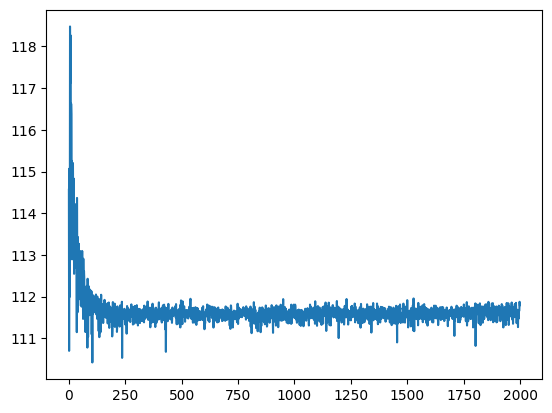

In [37]:
plt.plot(results_dict["is"])

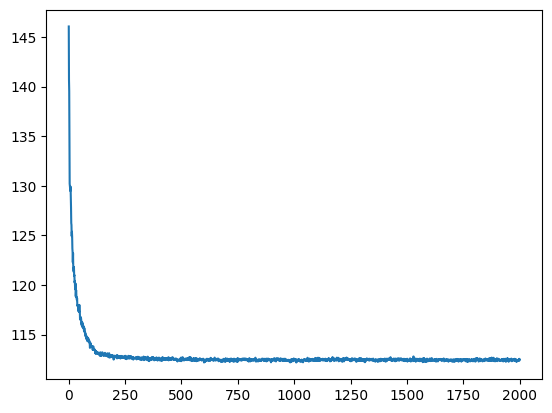

In [38]:
plt.plot(results_dict["elbo"])

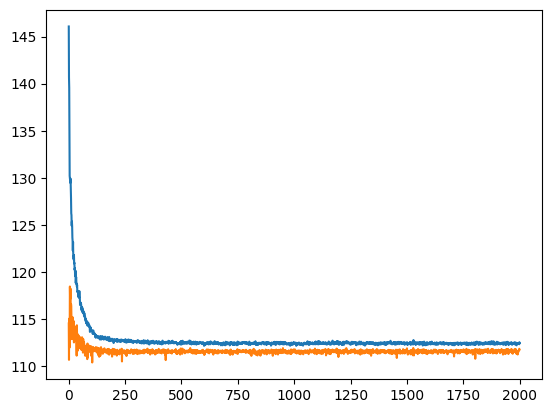

In [39]:
plt.plot(results_dict["elbo"])
plt.plot(results_dict["is"])